In [10]:
!pip install haystack-ai==2.10.3
!pip install azure-ai-search-haystack
!pip install jq
!pip install nltk=="3.9.1"
!pip install jsonschema
!pip install kagglehub

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Defaulting to user insta

In [12]:

import kagglehub
path = kagglehub.dataset_download("nelgiriyewithana/shoppersentiments")

In [13]:
import pandas as pd
from json import loads, dumps

path = "<Path to the CSV file>"

df = pd.read_csv(path, encoding='latin1', nrows=200) # We are using 200 rows for testing purposes

df.rename(columns={'review-label': 'rating'}, inplace=True)
df['year'] = pd.to_datetime(df['year'], format='%Y %H:%M:%S').dt.year

# Convert DataFrame to JSON
json_data = {"reviews": loads(df.to_json(orient="records"))}


In [18]:
from haystack.components.converters import JSONConverter
from haystack.dataclasses import ByteStream
converter = JSONConverter(
  jq_schema=".reviews[]", content_key="review", extra_meta_fields={"store_location", "date", "month", "year", "rating"}
)
source = ByteStream.from_string(dumps(json_data))

documents = converter.run(sources=[source])['documents']
documents = [doc for doc in documents if doc.content is not None] # remove documents with no content


In [19]:
from haystack.components.preprocessors import DocumentCleaner
cleaner = DocumentCleaner(ascii_only=True, remove_regex="i12i12i12")
cleaned_documents=cleaner.run(documents=documents)


In [22]:
from haystack import Pipeline
from haystack.components.embedders import AzureOpenAITextEmbedder, AzureOpenAIDocumentEmbedder
from haystack.components.writers import DocumentWriter
from azure.search.documents.indexes.models import (
    SemanticConfiguration,
    SemanticField,
    SemanticPrioritizedFields,
    SemanticSearch
)

from haystack_integrations.document_stores.azure_ai_search import AzureAISearchDocumentStore


semantic_config = SemanticConfiguration(
    name="my-semantic-config",
    prioritized_fields=SemanticPrioritizedFields(
        content_fields=[SemanticField(field_name="content")]
    )
)

# Create the semantic settings with the configuration
semantic_search = SemanticSearch(configurations=[semantic_config])

document_store = AzureAISearchDocumentStore(index_name="customer-reviews-analysis", api_key="your_api_key",
                                            endpoint="your_endpoint",
    embedding_dimension=1536, metadata_fields = {"month": int, "year": int, "rating": int, "store_location": str}, semantic_search=semantic_search)

# Indexing Pipeline
indexing_pipeline = Pipeline()
indexing_pipeline.add_component("document_embedder", AzureOpenAIDocumentEmbedder())
indexing_pipeline.add_component(instance=DocumentWriter(document_store=document_store), name="doc_writer")
indexing_pipeline.connect("document_embedder", "doc_writer")

indexing_pipeline.run({"document_embedder": {"documents": cleaned_documents["documents"]}})



Embedding Texts: 100%|██████████| 6/6 [00:29<00:00,  4.91s/it]


{'document_embedder': {'meta': {'model': 'text-embedding-ada-002',
   'usage': {'prompt_tokens': 4283, 'total_tokens': 4283}}},
 'doc_writer': {'documents_written': 175}}

In [23]:
from haystack_integrations.components.retrievers.azure_ai_search import AzureAISearchHybridRetriever

# Query Pipeline
query_pipeline = Pipeline()
query_pipeline.add_component("text_embedder", AzureOpenAITextEmbedder())
query_pipeline.add_component("retriever", AzureAISearchHybridRetriever(document_store=document_store, query_type="semantic", semantic_configuration_name="my-semantic-config", top_k=10))
query_pipeline.connect("text_embedder.embedding", "retriever.query_embedding")



🚅 Components
  - text_embedder: AzureOpenAITextEmbedder
  - retriever: AzureAISearchHybridRetriever
🛤️ Connections
  - text_embedder.embedding -> retriever.query_embedding (List[float])

In [26]:
query = "Which reviews are about shipping?"

# Retrieve reviews based on the query
result = query_pipeline.run({"text_embedder": {"text": query}, "retriever": {"query": query}})
retrieved_reviews = result["retriever"]["documents"]
print(retrieved_reviews)


<iterator object azure.core.paging.ItemPaged at 0x17f829880>
[Document(id=e9f8a141855701896441cbf9fd29ad326ec5250e9263f4ea1f74a5b389d1c90c, content: 'You did everything right! Shipping was quick and reasonable, and the shirts are awesome! Colorful an...', meta: {'store_location': 'US', 'year': 2018, 'rating': 5, 'month': 6}, embedding: vector of size 1536), Document(id=a841f950a433d05857933fb7cd46d54a6a04066f1373875359c90f096ce0bf9a, content: 'I love the shirts that I bought.Prices were great and shipping didnt take any lon', meta: {'store_location': 'US', 'year': 2024, 'rating': 5, 'month': 6}, embedding: vector of size 1536), Document(id=0ee4d9627e9085936973126762a0aa746b5e235cf253a9f759af84fbfdd9cdae, content: 'Product was great. Love the options. anything I could imagine was available. my only issue was I pai...', meta: {'store_location': 'US', 'year': 2023, 'rating': 4, 'month': 6}, embedding: vector of size 1536), Document(id=31bb2754ad0ebf5084c90260dd45f7c9ea8f5bf5759d3caaf7e974

# CREATE TOOLS FOR SENTIMENT ANALYSIS and SUMMARIZATION


In [27]:
!pip install vaderSentiment
!pip install matplotlib
!pip install sumy

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


In [28]:
# Function to visualize the sentiment distribution

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


def plot_sentiment_distribution(topics):
    # Create DataFrame from topics data
    data = [(topic, review['sentiment']['analyzer_rating'], 
             review['review']['rating'], review['sentiment']['label'])
            for topic, reviews in topics.items()
            for review in reviews]
    
    df = pd.DataFrame(data, columns=['Topic', 'Normalized Score', 'Original Rating', 'Sentiment'])
    
    # Calculate means
    df_means = df.groupby('Topic').agg({
        'Normalized Score': 'mean',
        'Original Rating': 'mean'
    }).reset_index()
    
    fig, ax = plt.subplots(figsize=(8, 4))  
    x = np.arange(len(df_means))
    bar_width = 0.3  
    
    # Colors for sentiment
    colors = {
        'positive': '#2ecc71',
        'neutral': '#f1c40f',
        'negative': '#e74c3c'
    }
    
    # Create bars
    sentiment_colors = [colors[df.groupby('Topic')['Sentiment'].agg(lambda x: x.mode()[0])[topic]] 
                       for topic in df_means['Topic']]
    
    bars1 = ax.bar(x - bar_width/2, df_means['Normalized Score'], 
                   bar_width, label='Normalized Score', color=sentiment_colors)
    bars2 = ax.bar(x + bar_width/2, df_means['Original Rating'], 
                   bar_width, label='Original Rating', color='gray', alpha=0.7)
    
    # Customize plot with smaller font sizes
    ax.set_ylabel('Score', fontsize=9)
    ax.set_title('Average Sentiment Scores by Topic', fontsize=10)
    ax.set_xticks(x)
    ax.set_xticklabels(df_means['Topic'], rotation=45, ha='right', fontsize=8)
    ax.tick_params(axis='y', labelsize=8)
    
    # Add value labels with smaller font size
    for bars in [bars1, bars2]:
        ax.bar_label(bars, fmt='%.2f', padding=3, fontsize=8)
    
    # Smaller legend
    ax.legend(handles=[plt.Rectangle((0,0),1,1, color=c) for c in colors.values()] + 
             [plt.Rectangle((0,0),1,1, color='gray', alpha=0.7)],
             labels=list(colors.keys()) + ['Original Rating'],
             loc='upper right',
             fontsize=8)
    
    plt.tight_layout()
    plt.show()

In [47]:
from haystack.tools import Tool
from haystack.components.tools import ToolInvoker

from typing import Dict, List
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


def analyze_sentiment(reviews: List[Dict]) -> Dict:
    """
    Perform aspect-based sentiment analysis.
    
    For each review that mentions keywords related to a specific topic, the function computes 
    sentiment scores using VADER and categorizes the sentiment as 'positive', 'negative', or 'neutral'.
    
    """
    topics = {
        "product_quality": [],
        "shipping": [],
        "customer_service": [],
        "pricing": []
    }
    
    # Define keywords for each topic
    keywords = {
        "product_quality": ["quality", "material", "design", "fit", "size", "color", "style"],
        "shipping": ["shipping", "delivery", "arrived"],
        "customer_service": ["service", "support", "help"],
        "pricing": ["price", "cost", "expensive", "cheap"]
    }

    
    # Initialize the VADER sentiment analyzer
    analyzer = SentimentIntensityAnalyzer()
    
    for review in reviews:
        text = review.get("review", "").lower()
        for topic, words in keywords.items():
            if any(word in text for word in words):
                # Compute sentiment scores using VADER
                sentiment_scores = analyzer.polarity_scores(text)
               
                compound = sentiment_scores['compound']
                # Normalize compound score from [-1, 1] to [1, 5]
                normalized_score = (compound + 1) * 2 + 1
                
                if compound >= 0.03:
                    sentiment_label = 'positive'
                elif compound <= -0.03:
                    sentiment_label = 'negative'
                else:
                    sentiment_label = 'neutral'
                
                # Append the review along with its sentiment analysis result
                topics[topic].append({
                    "review": review,
                    "sentiment": {
                        "analyzer_rating": normalized_score,
                        "label": sentiment_label
                    }
                })
    plot_sentiment_distribution(topics)

    return {
        "total_reviews": len(reviews),
        "sentiment_analysis": topics,
        "average_rating": sum(r.get("rating", 3) for r in reviews) / len(reviews)
    }

# Create the aspect based sentiment analysis tool
sentiment_tool = Tool(
    name="review_analysis",
    description="Aspect based sentiment analysis tool that compares the sentiment of reviews by analyzer and rating",
    function=analyze_sentiment,
    parameters={
        "type": "object",
        "properties": {
            "reviews": {
                "type": "array",
                "items": {
                    "type": "object",
                    "properties": {
                        "review": {"type": "string"},
                        "rating": {"type": "integer"},
                        "date": {"type": "string"}
                    }
                }
            },
        },
        "required": ["reviews"]
    }
)



In [54]:
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lsa import LsaSummarizer
from haystack.tools import create_tool_from_function


def summarize_reviews(reviews: List[Dict]) -> Dict:
    """
    Summarize the reviews by extracting key sentences.
    """
    summaries = []
    summarizer = LsaSummarizer()
    for review in reviews:
        text = review.get("review", "")
        parser = PlaintextParser.from_string(text, Tokenizer("english"))
        summary = summarizer(parser.document, 2)  # Adjust the number of sentences as needed
        summary_text = " ".join(str(sentence) for sentence in summary)
        summaries.append({"review": text, "summary": summary_text})

    return {"summaries": summaries}

# Create the text summarization tool
summarization_tool = Tool(
    name="review_summarization",
    description="Tool to summarize customer reviews by extracting key sentences.",
    function=summarize_reviews,
    parameters={
        "type": "object",
        "properties": {
            "reviews": {
                "type": "array",
                "items": {
                    "type": "object",
                    "properties": {
                        "review": {"type": "string"},
                        "rating": {"type": "integer"},
                        "date": {"type": "string"}
                    }
                }
            },
        },
        "required": ["reviews"]
    }
)


In [55]:
from haystack.dataclasses import ChatMessage
from haystack.components.generators.chat import AzureOpenAIChatGenerator

def create_review_agent():
    """Creates an interactive review analysis agent"""
    
    chat_generator = AzureOpenAIChatGenerator(
        tools=[sentiment_tool, summarization_tool]
    )
    
    system_message = ChatMessage.from_system(
        """
        You are a customer review analysis expert. Your task is to perform aspect based sentiment analysis on customer reviews.
        You can use two tools to get insights:
        - review_analysis: to get the sentiment of reviews by analyzer and rating
        - review_summarization: to get the summary of reviews.

        Depending on the user's question, use the appropriate tool to get insights and explain them in a helpful way. 
        
        """
    )
    
    return chat_generator, system_message

tool_invoker = ToolInvoker(tools=[sentiment_tool, summarization_tool])



🧑: Whats the overall sentiment distribution?
⌛ iterating...

 TOOL CALL:
	review_analysis


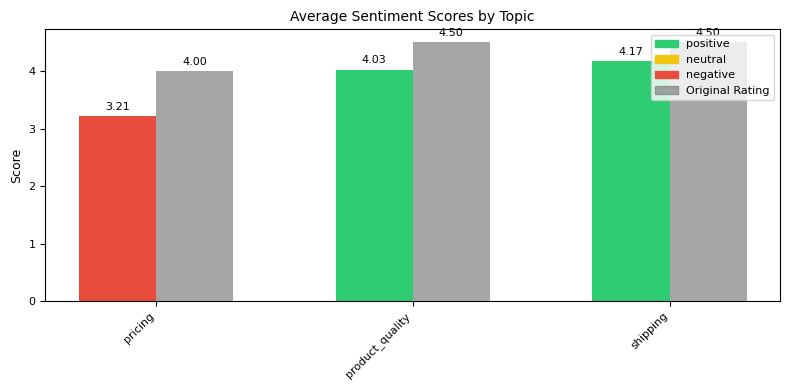

⌛ iterating...
🤖: The overall sentiment analysis of the customer reviews reveals a predominantly positive sentiment, as evidenced by the following key insights:

### Sentiment Distribution:
1. **Total Reviews Analyzed**: 10
2. **Average Rating**: 4.6 out of 5

### Breakdown by Aspects:
- **Product Quality**: All reviews regarding product quality are rated positively, with an average sentiment analyzer rating of approximately 4.37. Customers expressed satisfaction with shirt designs, quality, and options.
  
- **Shipping**: Shipping also received positive feedback, with reviews indicating quick and efficient shipping times. The sentiment analyzer rating for shipping-related comments is around 4.65, with a majority of users finding the shipping service excellent.

- **Pricing**: Pricing feedback is mixed, with some customers finding the prices reasonable, while others viewed them as somewhat high. The sentiment analyzer rating for pricing stands at approximately 1.73 for the negative fee

In [56]:
# Create the review assistant
chat_generator, system_message = create_review_agent()

# Initialize messages with the system message
messages = [system_message]

# Interactive loop for user input
while True:
    user_input = input("\n\nwaiting for input (type 'exit' or 'quit' to stop)\n: ")
    if user_input.lower() == "exit" or user_input.lower() == "quit":
        break
    messages.append(ChatMessage.from_user(user_input))

    print (f"\n🧑: {user_input}")
    # Build the prompt with user input and reviews
    user_prompt = ChatMessage.from_user(f"""
    {user_input}
    Here are the reviews with analysis:
    {retrieved_reviews}
    """)
    messages.append(user_prompt)

    while True:
        print("⌛ iterating...")

        replies = chat_generator.run(messages=messages)["replies"]
        messages.extend(replies)

        # Check for tool calls and handle them
        if not replies[0].tool_calls:
            break
        tool_calls = replies[0].tool_calls

        # Print tool calls for debugging
        for tc in tool_calls:
            print("\n TOOL CALL:")
            print(f"\t{tc.tool_name}")

        tool_messages = tool_invoker.run(messages=replies)["tool_messages"]
        messages.extend(tool_messages)

    # Print the final AI response after all tool calls are resolved
    print(f"🤖: {messages[-1].text}")

